In [1]:
#!pip install diffusers torch torchvision tqdm

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch import nn
from torch.optim import AdamW
import math
import matplotlib.pyplot as plt

# Custom Dataset class
class CatDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_filenames = [os.path.join(img_dir, file) for file in os.listdir(img_dir) if file.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),        # Convert to Tensor (0-1 values)
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Initialize dataset and dataloader
train_dataset = CatDataset(img_dir='data/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define model
model = UNet2DModel(
    sample_size=64,    # Input image resolution
    in_channels=3,     # Number of input channels (RGB)
    out_channels=3,    # Output channels
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Feature map size at each UNet block
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),  # Downsampling
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "AttnUpBlock2D"),  # Upsampling
)

# Diffusion scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

# Loss function
mse_loss = nn.MSELoss()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Directory to save generated images
output_dir = "./generated_images"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Function to generate and save a 4x4 grid of images
def generate_and_save_images(model, step, scheduler, device, output_dir):
    # Generate 16 random noise images (4x4 grid)
    model.eval()
    with torch.no_grad():
        noise = torch.randn(16, 3, 64, 64).to(device)  # 16 images, 3 channels, 64x64 size
        timesteps = torch.full((16,), scheduler.num_train_timesteps - 1, device=device, dtype=torch.long)
        
        # Progressively remove noise (denoising process)
        for t in range(scheduler.num_train_timesteps - 1, -1, -1):
            timesteps.fill_(t)
            noise_pred = model(noise, timesteps).sample
            noise = scheduler.step(noise_pred, t, noise).prev_sample

        # Denormalize [-1, 1] -> [0, 1]
        generated_images = (noise.clamp(-1, 1) + 1) / 2.0

        # Create a 4x4 grid of images
        grid = make_grid(generated_images, nrow=4)

        # Convert to PIL image and save
        grid_image = transforms.ToPILImage()(grid.cpu())
        grid_image.save(os.path.join(output_dir, f"generated_step_{step}.png"))

    model.train()

In [ ]:
# Training loop
epochs = 200
num_validation_images = 8  # Set a number of validation images for quick validation
save_interval = 200       # Save every 1000 steps
global_step = 0            # Track global step count

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
    
    for batch in progress_bar:
        batch = batch.to(device)
        global_step += 1

        # Sample noise to add to the images
        noise = torch.randn_like(batch).to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()

        # Get the noisy image based on the current timestep
        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)

        # Predict the noise
        noise_pred = model(noisy_images, timesteps).sample

        # Calculate loss (how well the model predicts the noise)
        loss = mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        progress_bar.set_postfix(train_loss=loss.item())
        
        # Generate and save images every 1000 steps
        if global_step % save_interval == 0:
            generate_and_save_images(model, global_step, noise_scheduler, device, output_dir)
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(num_validation_images):
            batch = next(iter(train_loader)).to(device)  # Take some samples from the training set as "validation"
            noise = torch.randn_like(batch).to(device)
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()
            noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = mse_loss(noise_pred, noise)
            val_loss += loss.item()

    avg_val_loss = val_loss / num_validation_images
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")


In [4]:
save_model = False

if save_model:
    # Save the trained model after training is complete
    checkpoint_path = "model_final_cats.pth"
    torch.save({
        'epoch': epochs,  # Total number of epochs
        'model_state_dict': model.state_dict(),  # Model parameters
        'optimizer_state_dict': optimizer.state_dict(),  # Optimizer parameters
        'train_loss': avg_train_loss,  # Final training loss
        'val_loss': avg_val_loss,  # Final validation loss
    }, checkpoint_path)
    
    print(f"Training complete. Model saved as {checkpoint_path}")

In [5]:
checkpoint = torch.load("model_final.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

model.eval()  # Set the model to evaluation mode for inference

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

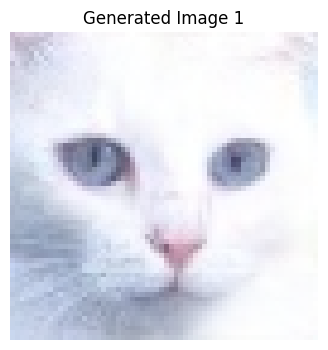

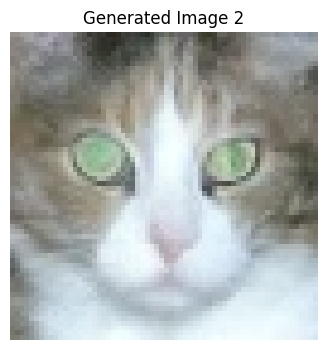

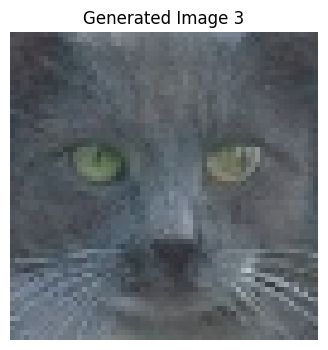

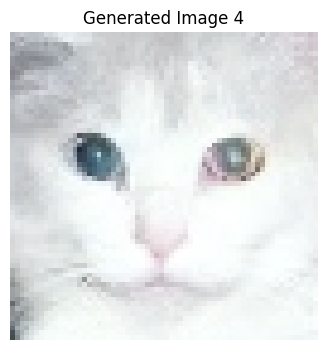

In [12]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# Set model to evaluation mode
model.eval()

# Loop to generate and plot 4 images
for i in range(4):
    with torch.no_grad():
        # Generate random noise (1 image, 3 channels, 64x64 size)
        noise = torch.randn(1, 3, 64, 64).to(device)
        timesteps = torch.full((1,), noise_scheduler.num_train_timesteps - 1, device=device, dtype=torch.long)

        # Denoising process (removing noise progressively)
        for t in range(noise_scheduler.num_train_timesteps - 1, -1, -1):
            timesteps.fill_(t)
            noise_pred = model(noise, timesteps).sample
            noise = noise_scheduler.step(noise_pred, t, noise).prev_sample

        # Denormalize image from [-1, 1] to [0, 1] range for visualization
        generated_image = (noise.clamp(-1, 1) + 1) / 2.0

        # Convert to (H, W, C) format for plotting
        generated_image = generated_image.squeeze(0).cpu().permute(1, 2, 0).numpy()

        # Plot the generated image
        plt.figure(figsize=(4, 4))
        plt.imshow(generated_image)
        plt.title(f"Generated Image {i+1}")
        plt.axis('off')  # Hide axes for clean output
        plt.show()